# PA005 - High Value Customers Identification (Insiders)

## 0.0 Planejamento da Solução (IOT)

### Input - Entrada

1. Problema de negócio
- Selecionar os clientes mais valiosos para integrar um programa de fidelização.
2. Conjunto de Dados
- Vendas de um e-commerce, durante um certo período.

### Output  - Saída
1. A indicação das pessoas que farão parte do programa de Insiders.
- Lista: client_id| is_insider |

2. Relatório com as respostas das perguntas de negócio.
- Quem são as pessoas elegíveis para participar do programa de Insiders?
- Quantos clientes farão parte do grupo?
- Quais as principais características desses clientes?
- Qual a % de contribuição do faturamento, vinda do Insiders?
- Qual a expectativa de faturamento desse grupo para os próximos meses?
- Quais as condições para uma pessoa ser elegível ao Insiders?
- Quais as condições para uma pessoa ser removida do Insiders?
- Qual a garantia que o programa Insiders é melhor que o restante da base?
- Quais ações o time de marketing pode realizar para aumentar o faturamento?

### Tasks - Tarefas


1. Quem são as pessoas elegíveis para participar do programa de Insiders?
    - O que é ser elegível? O que são clientes de alto "valor"?
    - Faturamento:
        - Alto ticket médio.
        - Alto LTV.
        - Baixa Recência.
        - Alto basket size.
        - Baixa probabilidade de Churn.
        - Alta Previsão LTV.
        - Alta propensão de compra.

    - Custo:
        - Baixa taxa de devolução.
    
    - Experiência de compra:
        - Média alta das avaliações.

2. Quantos clientes farão parte do grupo?
    - Número total de clientes.
    - % do grupo Insiders.

3. Quais as principais características desses clientes?
    - Escrever características dos clientes:
        - Idade
        - Salário
        - Localização
    
    - Escrever características de consumo:
        - Atributos de clusterização

4. Qual a % de contribuição do faturamento, vinda do Insiders?
    - Faturamento total do ano.
    - Faturamento do grupo Insiders.

5. Qual a expectativa de faturamento desse grupo para os próximos meses?
    - Previsão do LTV do grupo Insiders.
    - Análise de Cohort.

6. Quais as condições para uma pessoa ser elegível ao Insiders?
    - Definir a periodicidade ( 1 mês, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa do grupo.
7. Quais as condições para uma pessoa ser removida do Insiders?
    - Definir a periodicidade ( 1 mês, 3 meses)
    - A pessoa precisa ser desimilar ou não-parecido com uma pessoa do grupo.
8. Qual a garantia que o programa Insiders é melhor que o restante da base?
    - Teste A/B.
    - teste A/B Bayesiano.
    - Teste de hióteses.
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto.
    - Preferência de compra.
    - Frete.
    - Visita a empresa.

## Benchmark de soluções

### 1.0 Desk Research

# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re

import umap.umap_ as umap

from ydata_profiling import ProfileReport
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from plotly import express as px
from matplotlib import pyplot as plt
from sklearn import cluster as c
from sklearn import preprocessing as pp
from sklearn import metrics as mt
from sklearn.decomposition import PCA

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1 Helper Functions

## 0.2 Loading Dataset

In [2]:
# load data
df_raw = pd.read_csv('../data/Ecommerce.csv', encoding='latin1')

# drop extra column
df_raw = df_raw.drop('Unnamed: 8', axis = 1)

# 1.0 Descrição dos Dados

In [3]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [4]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id','country']
df1.columns = cols_new

## 1.2 Data Dimensions, Types e NA

In [5]:
df1.shape

(541909, 8)

## 1.3 Datatypes

In [6]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [7]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [8]:
# remove na
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

invoice_number_missing = df_missing.loc[:, 'invoice_no'].tolist()
df_not_missing.loc[df_not_missing['invoice_no'].isin(invoice_number_missing), :]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


In [9]:
df_not_missing['customer_id'].max()

18287.0

In [10]:
# create reference
df_backup = pd.DataFrame(df_missing[['invoice_no']].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000 + len(df_backup), 1)

# merge with original dataframe
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'])

## 1.6 Change Datatypes

In [11]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

## 1.7 Descriptive Statistics

In [12]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [13]:
# Central Tendecy (Mean and Median)
c1 = pd.DataFrame(num_attributes.apply(lambda x: np.mean(x)))
c2 = pd.DataFrame(num_attributes.apply(lambda x: np.median(x)))

# Dispersion
d1 = pd.DataFrame(num_attributes.apply(lambda x: (x).min()))
d2 = pd.DataFrame(num_attributes.apply(lambda x: (x).max()))
d3 = pd.DataFrame(num_attributes.apply(lambda x: (x).max() - (x).min()))
d4 = pd.DataFrame(num_attributes.apply(lambda x: np.std(x)))
d5 = pd.DataFrame(num_attributes.apply(lambda x: (x).skew()))
d6 = pd.DataFrame(num_attributes.apply(lambda x: (x).kurtosis()))

a = pd.concat([d1,d2,d3, c1,c2,d4,d5,d6], axis = 1)
a.columns = ['min', 'max','range','mean','median','std','skew','kurtosis']
a

,min,max,range,mean,median,std,skew,kurtosis
quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### 1.7.1.1 Investigating
1. Quantity negativa (pode ser devolução?)
2. Quantidade muito alta.
3. Preço unitário igual a 0 (pode ser brinde?).
4. Preço unitário alto

### 1.7.2 Categorical Attributes

In [14]:
# invoice_no

# df1['invoice_no'] = df1['invoice_no'].astype(int)
df_invoice_no = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x) ) ), :]
quantity_negative = df_invoice_no.loc[df_invoice_no['quantity'] < 0, 'quantity'].count()

print(f'Quantidade de invoice number com letras: {df_invoice_no.shape[0]} e que tem quantidade negativa: {quantity_negative}')

Quantidade de invoice number com letras: 9291 e que tem quantidade negativa: 9288


In [15]:
# stock_code

# df1['stock_code'] = df1['stock_code'].astype(int)
# len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x) ) ), 'stock_code'].drop_duplicates())

stock_code_limpeza = list(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x) ) ), 'stock_code'].unique())

print(f'Lista de stock code para limpar: {stock_code_limpeza}')

Lista de stock code para limpar: ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']


In [16]:
# country_code
cat_attributes.loc[:, 'country'].value_counts(normalize = True)
cat_attributes.loc[:, 'country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

# 2.0 Filtragem de Variáveis

In [58]:
df2 = df1.copy()

In [59]:
# ======== unit_price ========
df2 = df2[df2['unit_price'] >= 0.04]

# ======== stock_code ========
df2 = df2[~df2['stock_code'].isin(stock_code_limpeza)]

# ======== description ========
df2 = df2.drop(columns='description', axis = 1)
 
# ======== country ========
df2 = df2[~df2['country'].isin(['European Community','Unspecified'])]

# ======== bad users ========
df2 = df2[~(df2['customer_id'].isin( [16446] ))]

# ======== quantity ========
df2_purchases = df2[df2['quantity'] >= 0]
df2_returns = df2[df2['quantity'] < 0]


# 3.0 Feature Enginnering

In [60]:
df3 = df2.copy()

## 3.1 Feature Creation

In [61]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity','invoice_date','unit_price','country'], axis = 1).drop_duplicates(ignore_index = True)

### 3.1.1 Gross Revenue

In [62]:
# Gross Revenue (Faturamento) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on ='customer_id', how='left')
df_ref.isna().sum()

/tmp/ipykernel_1442/4216613857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency Days from the last purchase

In [63]:
# Recency - Last day purchase
df_recency = df2_purchases[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on ='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3 Quantity of purchases

In [64]:
df_purch = df2_purchases.loc[:, ['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no': 'purchases'})
df_ref = pd.merge(df_ref, df_purch, on ='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
purchases        91
dtype: int64

### 3.1.4 Quantity of unique products purchased

In [65]:
df_products_purch = df2_purchases.loc[:, ['customer_id','stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code': 'unique_products_purchased'})
df_ref = pd.merge(df_ref, df_products_purch, on ='customer_id', how='left')
df_ref.isna().sum()

customer_id                   0
gross_revenue                91
recency_days                 91
purchases                    91
unique_products_purchased    91
dtype: int64

### 3.1.5 Quantity of Items purchased

In [66]:
df_items_purch = df2_purchases.loc[:, ['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'items_purchased'})
df_ref = pd.merge(df_ref, df_items_purch, on ='customer_id', how='left')
df_ref.isna().sum()

customer_id                   0
gross_revenue                91
recency_days                 91
purchases                    91
unique_products_purchased    91
items_purchased              91
dtype: int64

### 3.1.6 Avg Ticket Value

In [67]:
df_gross = df2_purchases.loc[:, ['customer_id', 'invoice_no','gross_revenue']].groupby(['customer_id','invoice_no']).sum().reset_index()
df_ticket = df_gross.loc[:,['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, df_ticket, on ='customer_id', how='left')
df_ref.isna().sum()


customer_id                   0
gross_revenue                91
recency_days                 91
purchases                    91
unique_products_purchased    91
items_purchased              91
avg_ticket                   91
dtype: int64

In [68]:
# # Avg ticket
# df_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
# df_ref = pd.merge(df_ref, df_ticket, on ='customer_id', how='left')
# df_ref.isna().sum()

### 3.1.7 Avg Recency Days

In [69]:
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=[True, True])
df_aux['next_customer_id'] = df_aux['customer_id'].shift()
df_aux['previous_date'] = df_aux['invoice_date'].shift()

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis = 1)

df_aux = df_aux.drop(columns=['invoice_date', 'next_customer_id', 'previous_date'], axis = 1).dropna()

df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()
df_ref = pd.merge(df_ref, df_avg_recency_days, on ='customer_id', how='left')
df_ref.isna().sum()

customer_id                     0
gross_revenue                  91
recency_days                   91
purchases                      91
unique_products_purchased      91
items_purchased                91
avg_ticket                     91
avg_recency_days             2816
dtype: int64

### 3.1.8 Frequency Purchase

In [70]:
df_aux = (df2_purchases[['customer_id','invoice_no', 'invoice_date']].drop_duplicates()
                                                           .groupby('customer_id')
                                                           .agg( max = ('invoice_date', 'max'), 
                                                                 min = ('invoice_date', 'min'),
                                                                 days_ = ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                 buy_ = ('invoice_no', 'count')) ).reset_index()
                                                                 
df_aux['frequency'] = df_aux.apply(lambda x: x['buy_'] / x['days_'], axis = 1)

df_ref = pd.merge(df_ref, df_aux[['customer_id','frequency']], on ='customer_id', how='left')
df_ref.isna().sum()

customer_id                     0
gross_revenue                  91
recency_days                   91
purchases                      91
unique_products_purchased      91
items_purchased                91
avg_ticket                     91
avg_recency_days             2816
frequency                      91
dtype: int64

### 3.1.9 Number of Orders Returned

In [71]:
# Number of Returns
df_number_returns = df2_returns.loc[:, ['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns = {'invoice_no': 'number_returns'})
df_ref = pd.merge(df_ref, df_number_returns, on ='customer_id', how='left')
df_ref.loc[df_ref['number_returns'].isna(), 'number_returns'] = 0  
df_ref.isna().sum()

customer_id                     0
gross_revenue                  91
recency_days                   91
purchases                      91
unique_products_purchased      91
items_purchased                91
avg_ticket                     91
avg_recency_days             2816
frequency                      91
number_returns                  0
dtype: int64

### 3.1.10 Monetary value of returns

In [72]:
# Number of Returns
df2_returns['monetary_returns'] = df2_returns.loc[:, ['customer_id','quantity','unit_price']].apply(lambda x: x['quantity'] * x['unit_price'] * (-1), axis = 1)
df2_monetary_returns = df2_returns.loc[:, ['customer_id','monetary_returns']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df2_monetary_returns, on ='customer_id', how='left')
df_ref.loc[df_ref['monetary_returns'].isna(), 'monetary_returns'] = 0  
df_ref.isna().sum()

/tmp/ipykernel_1442/2122528216.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_returns['monetary_returns'] = df2_returns.loc[:, ['customer_id','quantity','unit_price']].apply(lambda x: x['quantity'] * x['unit_price'] * (-1), axis = 1)


customer_id                     0
gross_revenue                  91
recency_days                   91
purchases                      91
unique_products_purchased      91
items_purchased                91
avg_ticket                     91
avg_recency_days             2816
frequency                      91
number_returns                  0
monetary_returns                0
dtype: int64

### 3.1.11 Basket Size - Quantity

In [73]:
df_aux = df2_purchases.loc[:, ['customer_id','invoice_no','quantity']].groupby('customer_id').agg(n_purchase = ('invoice_no', 'nunique'),
                                                                                         n_items = ('quantity', 'sum')).reset_index()
                                                                                    
df_aux['avg_basket_size'] = df_aux['n_items'] / df_aux['n_purchase']
df_aux = df_aux[['customer_id','avg_basket_size']]

df_ref = pd.merge(df_ref, df_aux, on ='customer_id', how='left')
df_ref.isna().sum()

customer_id                     0
gross_revenue                  91
recency_days                   91
purchases                      91
unique_products_purchased      91
items_purchased                91
avg_ticket                     91
avg_recency_days             2816
frequency                      91
number_returns                  0
monetary_returns                0
avg_basket_size                91
dtype: int64

### 3.1.12 Unique Basket Size 

In [74]:
df_aux = df2_purchases.loc[:, ['customer_id','invoice_no','stock_code']].groupby('customer_id').agg(n_purchase = ('invoice_no', 'nunique'),
                                                                                         n_products = ('stock_code', 'count')).reset_index()
                                                                                    
df_aux['unique_avg_basket'] = df_aux['n_products'] / df_aux['n_purchase']
df_aux = df_aux[['customer_id','unique_avg_basket']]

df_ref = pd.merge(df_ref, df_aux, on ='customer_id', how='left')
df_ref.isna().sum()

customer_id                     0
gross_revenue                  91
recency_days                   91
purchases                      91
unique_products_purchased      91
items_purchased                91
avg_ticket                     91
avg_recency_days             2816
frequency                      91
number_returns                  0
monetary_returns                0
avg_basket_size                91
unique_avg_basket              91
dtype: int64

### 3.1.13 Delta_buy_return

In [75]:
df_ref['delta_buy_return'] = df_ref['gross_revenue'] - df_ref['monetary_returns']

# 4.0 EDA

In [76]:
df4 = df_ref.dropna()


## 4.1 Univariate Analysis

**Notes**
1. Clusters Coesos - Separados
2. Variabilidade
    - Métricas: Min, Máximo, Range (Dispersão)
    - Média e Mediana
    - Desvio Padrão e Variância.
    - Coeficiente de Variação. (comparar fundo de investimento)

**Notes**
1. Gross Revenue - Variabilidade Alta
2. Recency Days - Variabilidade
3. Purchases - Variabilidade
4. Unique Products Purchased - Variabilidade Média
5. Items Purchased - Alta Variabilidade
6. Avg Ticket 
    - Hipótese: Alta variabilidade mas muito causada pelos outliers errados
    - Sem um Outlier ficou variabilidade normal
7. Avg recency days - Baixa Variabilidade
8. Frequency - Alta Variabilidade
9. Number of Returns - Variabilidade Média
10. Monetary Returns - 
    - Hipótese - Variabilidade alta devido ao outlier
    - Variabilidade é alta
11. Avg basket size 
    - Hipótese - Variabilidade alta devido ao outlier
    - Variabilidade normal
12. Unique Avg Basket Size - Baixa variabilidade
13. Delta Buy Return - Alta variabilidade

In [77]:
# df_test_report = df4[(df4['customer_id'] != 16446)]
# profile = ProfileReport(df_test_report)
# profile.to_file('output_test.html')

In [78]:
# profile = ProfileReport(df4)
# profile.to_file('output.html')


### 4.1.1 Gross Revenue

In [79]:
df3[df3['customer_id'] == 14646].sort_values('quantity', ascending = False)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
421601,573003,23084,2400,2017-10-25,2.08,Netherlands,14646
409248,572052,22595,1728,2017-10-18,0.72,Netherlands,14646
63444,541570,21212,1440,2017-01-17,0.42,Netherlands,14646
534952,581175,23084,1440,2017-12-05,1.79,Netherlands,14646
186820,552883,21212,1200,2017-05-10,0.42,Netherlands,14646
...,...,...,...,...,...,...,...
271586,560710,23296,1,2017-07-18,1.25,Netherlands,14646
271584,560710,22567,1,2017-07-18,1.45,Netherlands,14646
271585,560710,23297,1,2017-07-18,1.65,Netherlands,14646
319805,C564899,22956,-144,2017-08-29,1.85,Netherlands,14646


In [80]:
df3[df3['customer_id'] == 18102].sort_values('quantity', ascending = True)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
439226,574383,23404,1,2017-11-02,3.26,United Kingdom,18102
439225,574383,82484,1,2017-11-02,4.80,United Kingdom,18102
373027,569257,23404,2,2017-10-01,3.26,United Kingdom,18102
439228,574383,22188,2,2017-11-02,2.31,United Kingdom,18102
439114,574355,22189,4,2017-11-02,2.31,United Kingdom,18102
...,...,...,...,...,...,...,...
540061,581457,23543,698,2017-12-06,4.15,United Kingdom,18102
16428,537657,22188,972,2016-12-05,2.31,United Kingdom,18102
16427,537657,22189,972,2016-12-05,2.31,United Kingdom,18102
16436,537659,22188,1008,2016-12-05,2.31,United Kingdom,18102


### 4.1.2 Purchases
- Cliente 12748 e 14911 compras ok

### 4.1.3 Items Purchased

In [81]:
df3[df3['customer_id'] == 14646	].sort_values('quantity', ascending = False)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
421601,573003,23084,2400,2017-10-25,2.08,Netherlands,14646
409248,572052,22595,1728,2017-10-18,0.72,Netherlands,14646
63444,541570,21212,1440,2017-01-17,0.42,Netherlands,14646
534952,581175,23084,1440,2017-12-05,1.79,Netherlands,14646
186820,552883,21212,1200,2017-05-10,0.42,Netherlands,14646
...,...,...,...,...,...,...,...
271586,560710,23296,1,2017-07-18,1.25,Netherlands,14646
271584,560710,22567,1,2017-07-18,1.45,Netherlands,14646
271585,560710,23297,1,2017-07-18,1.65,Netherlands,14646
319805,C564899,22956,-144,2017-08-29,1.85,Netherlands,14646


In [82]:
df4[df4['items_purchased'] == 196844]

,customer_id,gross_revenue,recency_days,purchases,unique_products_purchased,items_purchased,avg_ticket,avg_recency_days,frequency,number_returns,monetary_returns,avg_basket_size,unique_avg_basket,delta_buy_return
1017,14646,279138.02,1.0,72.0,2060.0,196844.0,3876.916944,7.844444,0.20339,1.0,360.0,2733.944444,28.611111,278778.02


### 4.1.4 AVG Ticket Value
- Customer 16446 - 2 compras efetivas e uma de 80995 itens que devolveu em seguida. 
- Customer 15749 - muitas compras devolvidas e de alto valor e metade do Gross Revenue foi devolvido.

### 4.1.5 Frequency
- Customer 17850 (frequência 17) ok

### 4.1.6 Number of Returns


In [83]:
df3[(df3['customer_id'] == 17841) & (df3['quantity'] < 0)].drop_duplicates('invoice_no')

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
1441,C536543,22632,-1,2016-11-29,2.10,United Kingdom,17841
6782,C536979,84685,-1,2016-12-01,3.75,United Kingdom,17841
58588,C541254,21667,-2,2017-01-14,14.95,United Kingdom,17841
64523,C541641,21671,-1,2017-01-18,1.25,United Kingdom,17841
68072,C541852,21781,-1,2017-01-21,14.95,United Kingdom,17841
88796,C543817,22179,-1,2017-02-11,6.75,United Kingdom,17841
93807,C544310,79160,-1,2017-02-15,2.10,United Kingdom,17841
104698,C545189,47594B,-1,2017-02-26,1.95,United Kingdom,17841
112062,C545866,21424,-1,2017-03-05,2.95,United Kingdom,17841
112065,C545867,21424,-1,2017-03-05,2.95,United Kingdom,17841


### 4.1.7 Monetary of Returns
- Customer 16029 - apesar de ter um delta positivo, realizou muitas devoluções


In [84]:
df3[(df3['customer_id'] == 16029) & (df3['quantity'] < 0)]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
43331,C540030,22070,-24,2017-01-02,3.75,United Kingdom,16029
121098,C546735,22933,-144,2017-03-14,2.10,United Kingdom,16029
121099,C546735,22932,-96,2017-03-14,2.10,United Kingdom,16029
121100,C546735,22930,-96,2017-03-14,2.10,United Kingdom,16029
390498,C570552,85099F,-100,2017-10-09,1.74,United Kingdom,16029
390499,C570552,85099B,-300,2017-10-09,1.74,United Kingdom,16029
390500,C570552,22961,-192,2017-10-09,1.25,United Kingdom,16029
390501,C570552,22386,-200,2017-10-09,1.74,United Kingdom,16029
390502,C570552,22207,-72,2017-10-09,3.75,United Kingdom,16029
390503,C570552,21931,-100,2017-10-09,1.74,United Kingdom,16029


In [85]:
df4[(df4['customer_id'] == 16029)]

,customer_id,gross_revenue,recency_days,purchases,unique_products_purchased,items_purchased,avg_ticket,avg_recency_days,frequency,number_returns,monetary_returns,avg_basket_size,unique_avg_basket,delta_buy_return
12,16029,72882.09,38.0,62.0,241.0,40207.0,1175.517581,9.054054,0.184524,4.0,14688.24,648.5,3.887097,58193.85


### 4.1.8 Avg Basket Size
- Customer 16446 - 80997 itens em uma compra mas devolveu tudo
- Customer 15749 - Comprou muitos itens em poucas compras mas devolveu muito.


### 4.1.9 Unique Avg Basket Size
- Outliers ok


### 4.1.10 Delta Buy Returns
- 3 clientes que tem um delta negativo, talvez tenham compras anteriores a data inicial da base de dados



In [86]:
df4[df4['delta_buy_return'] < 1]

,customer_id,gross_revenue,recency_days,purchases,unique_products_purchased,items_purchased,avg_ticket,avg_recency_days,frequency,number_returns,monetary_returns,avg_basket_size,unique_avg_basket,delta_buy_return
16,17548,103.30,233.0,1.0,5.0,58.0,103.300,78.0,1.000000,2.0,244.78,58.0,5.0,-1.414800e+02
132,16546,787.15,290.0,2.0,25.0,549.0,393.575,82.0,0.024096,1.0,883.08,274.5,12.5,-9.593000e+01
168,15823,15.00,372.0,1.0,1.0,1.0,15.000,35.0,1.000000,1.0,811.86,1.0,1.0,-7.968600e+02
1235,13672,186.39,301.0,2.0,6.0,57.0,93.195,16.0,0.062500,3.0,186.39,28.5,3.0,0.000000e+00
3122,13762,306.72,218.0,1.0,7.0,272.0,306.720,14.0,1.000000,1.0,306.72,272.0,7.0,5.684342e-14
4589,14557,788.38,85.0,1.0,16.0,510.0,788.380,21.0,1.000000,1.0,788.38,510.0,16.0,0.000000e+00
4605,16878,13.30,84.0,1.0,3.0,12.0,13.300,60.0,1.000000,1.0,13.30,12.0,3.0,0.000000e+00
4791,13364,134.96,71.0,1.0,10.0,71.0,134.960,5.0,1.000000,1.0,134.96,71.0,10.0,0.000000e+00
4897,14792,6.20,63.0,1.0,2.0,2.0,6.200,1.0,1.000000,1.0,6.20,2.0,2.0,0.000000e+00
4959,12607,1579.51,60.0,1.0,101.0,1228.0,1579.510,2.0,1.000000,1.0,1579.51,1228.0,101.0,0.000000e+00


## 4.2 Bivariate Analysis

In [87]:
cols = ['customer_id']
df42 = df4.drop(cols, axis = 1)

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1498:

<Figure size 2000x500 with 0 Axes>

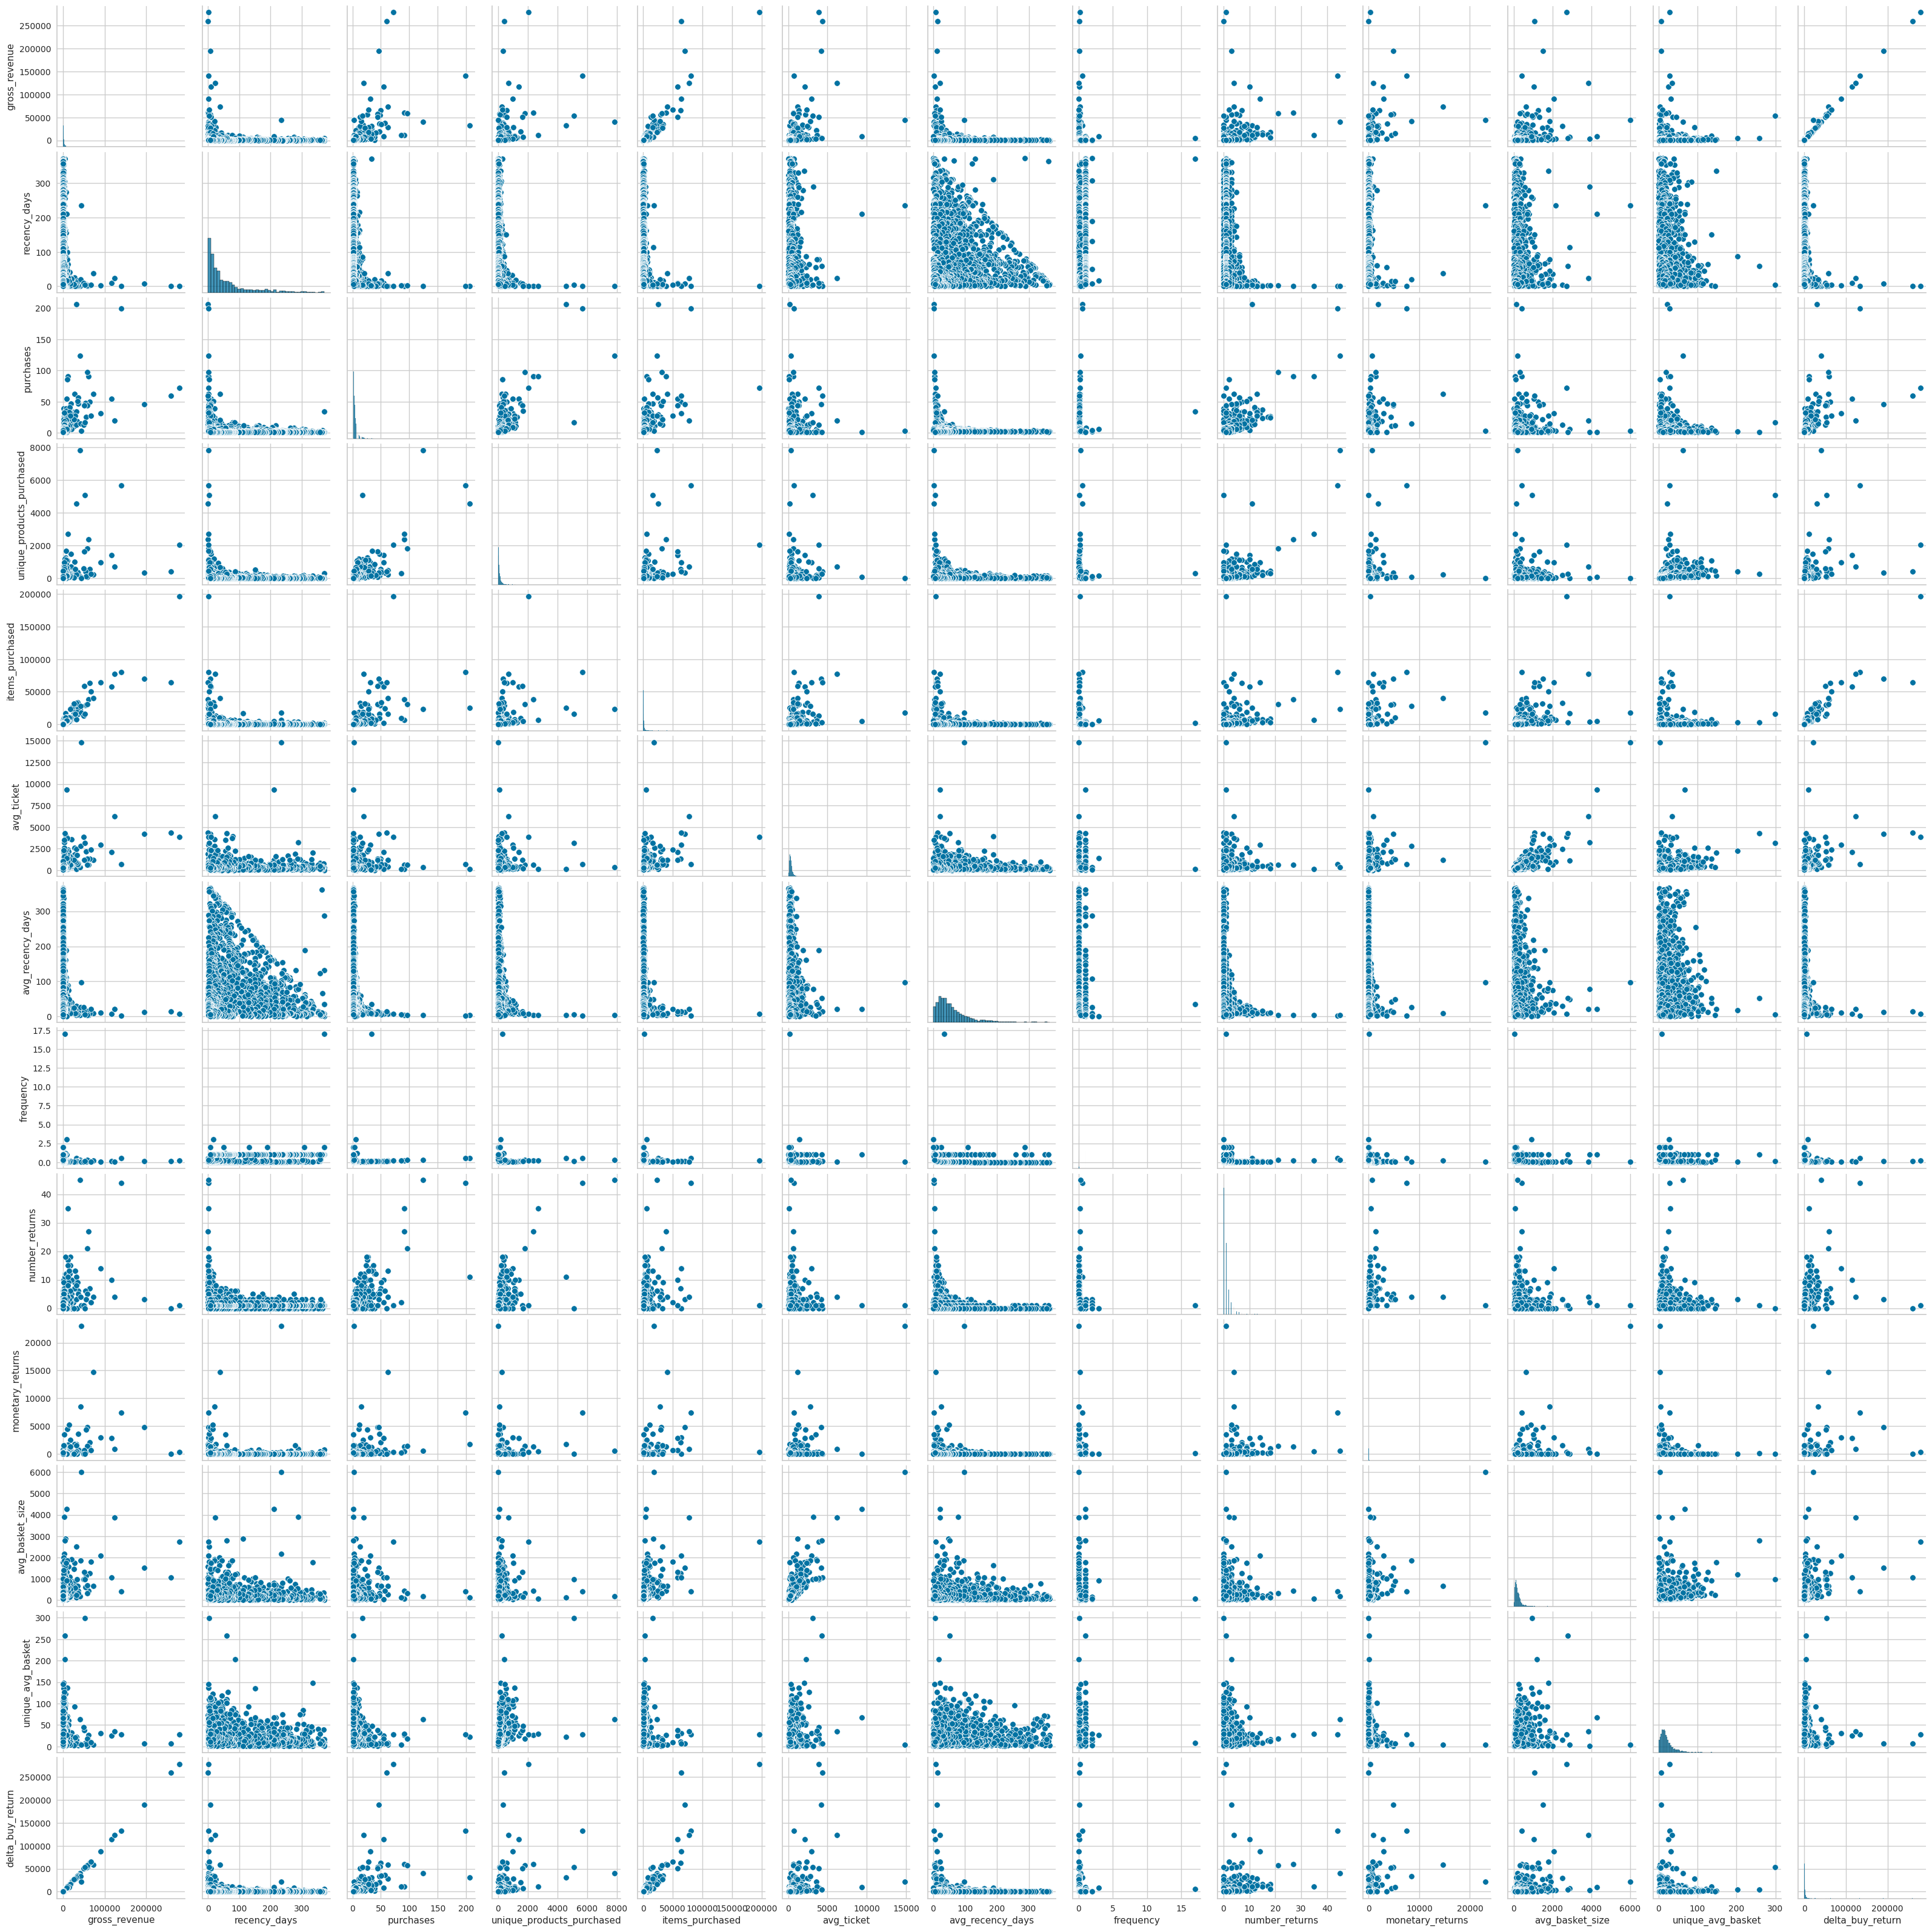

In [88]:
plt.figure(figsize=(20, 5))
sns.pairplot(df42)

**Notes** 
1. Frequency has low variance.
2. Avg ticket has low variance.
3. Monetary returns has low variance.

## 4.3 Estudo do Espaço

In [46]:
df43 = df4.drop(columns=['customer_id','gross_revenue'], axis = 1).copy()

In [47]:
mms = pp.MinMaxScaler()

In [48]:
# df43['gross_revenue'] = mms.fit_transform(df43[['gross_revenue']])
df43['recency_days'] = mms.fit_transform(df43[['recency_days']])
df43['purchases'] = mms.fit_transform(df43[['purchases']])
df43['unique_products_purchased'] = mms.fit_transform(df43[['unique_products_purchased']])
df43['items_purchased'] = mms.fit_transform(df43[['items_purchased']])
df43['avg_ticket'] = mms.fit_transform(df43[['avg_ticket']])
df43['avg_recency_days'] = mms.fit_transform(df43[['avg_recency_days']])
df43['frequency'] = mms.fit_transform(df43[['frequency']])
df43['number_returns'] = mms.fit_transform(df43[['number_returns']])
df43['monetary_returns'] = mms.fit_transform(df43[['monetary_returns']])
df43['avg_basket_size'] = mms.fit_transform(df43[['avg_basket_size']])
df43['unique_avg_basket'] = mms.fit_transform(df43[['unique_avg_basket']])
df43['delta_buy_return'] = mms.fit_transform(df43[['delta_buy_return']])

X = df43.copy()

### 4.3.1 PCA

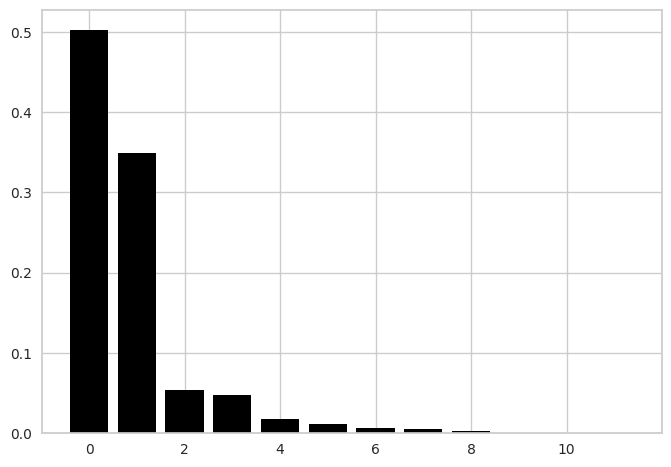

In [49]:

pca = PCA(n_components=X.shape[1])
principals_components = pca.fit_transform(X)

# Plot explained variance ratio
features = range(pca.n_components_)

plt.rcParams['font.family'] = 'DejaVu Sans'

plt.bar(features, pca.explained_variance_ratio_, color = 'black')
plt.show()

# pca component
df_pca = pd.DataFrame(principals_components)

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='0', ylabel='1'>

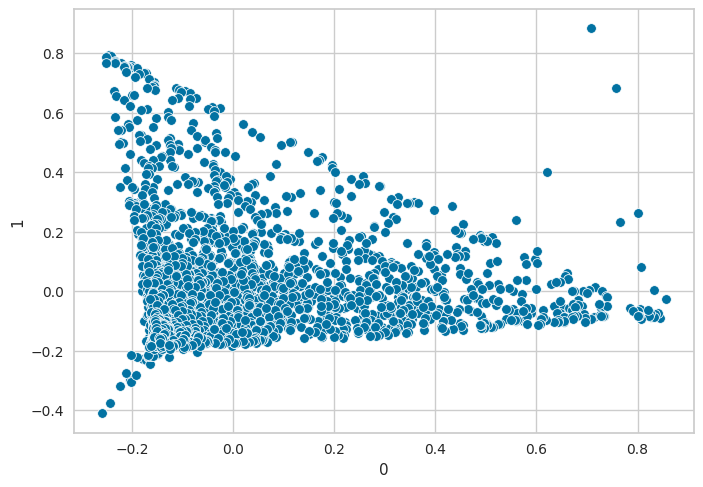

In [50]:
sns.scatterplot(x=0, y=1, data = df_pca)

### 4.3.2 UMAP

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

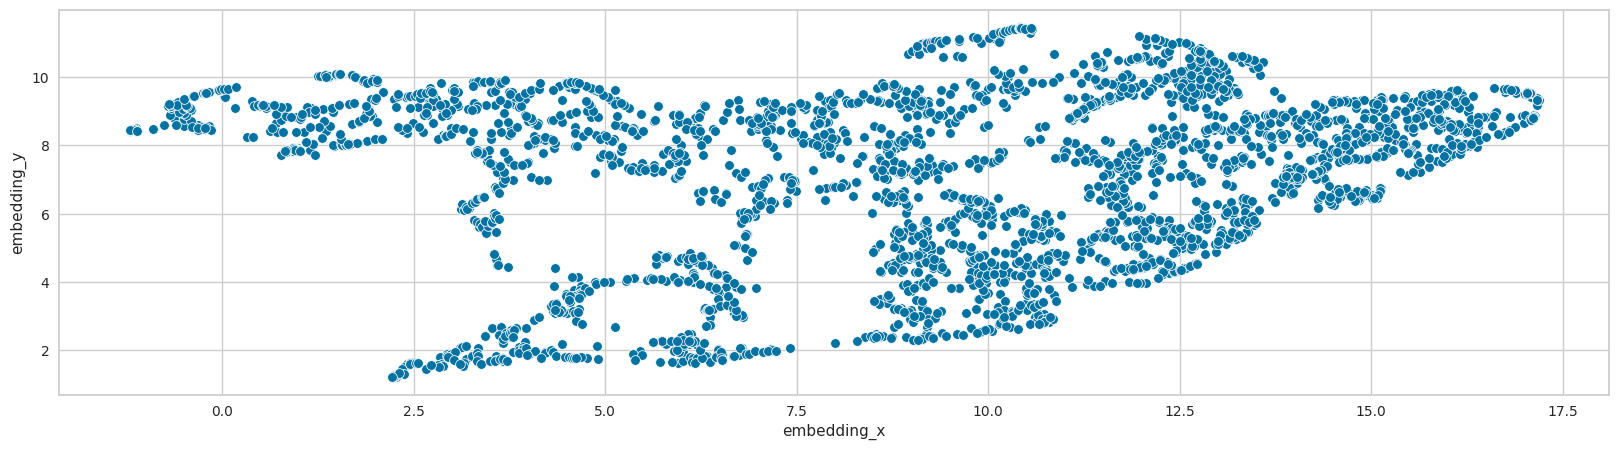

In [51]:
reducer = umap.UMAP(random_state= 42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
plt.figure(figsize=(20,5))
sns.scatterplot(x='embedding_x', y='embedding_y', data = df_pca)


### 4.3.3 t-SNE

In [52]:
from sklearn.manifold import TSNE

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

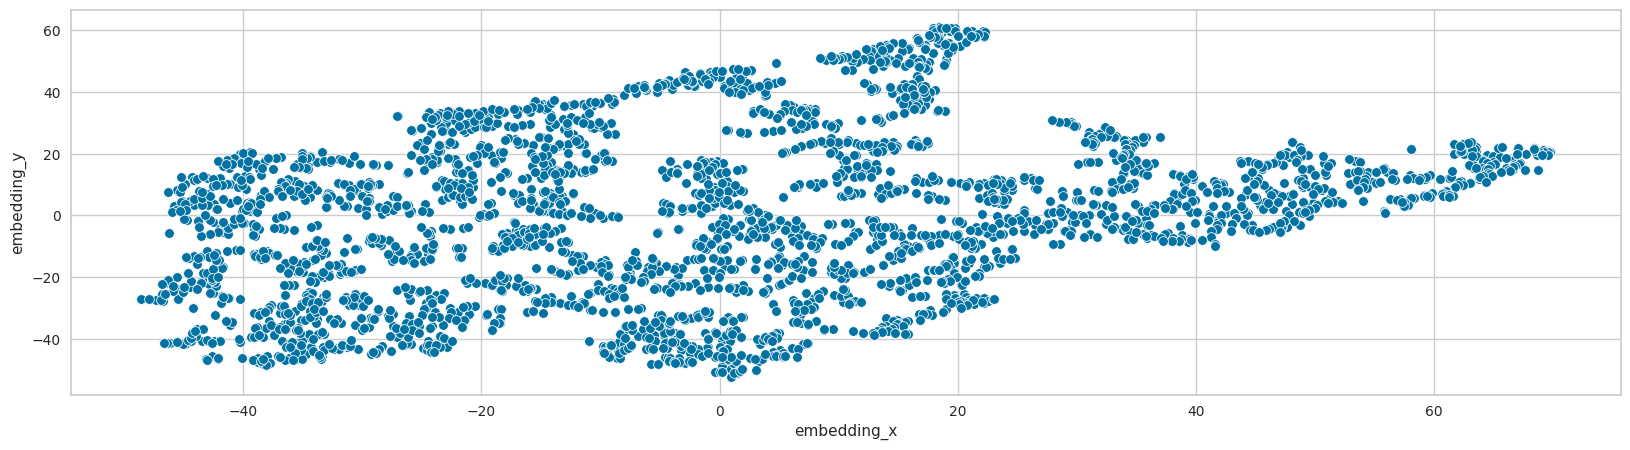

In [53]:
reducer = TSNE(n_components = 2, n_jobs = -1 ,random_state= 42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
plt.figure(figsize=(20,5))
sns.scatterplot(x='embedding_x', y='embedding_y', data = df_pca)


### 4.3.4 Tree Based Embedding

In [54]:
from sklearn.ensemble import RandomForestRegressor

In [55]:
# training dataset
X = df4.drop(columns=['customer_id','gross_revenue','delta_buy_return'])
y = df4['delta_buy_return'].copy()


# model definition
rf_model = RandomForestRegressor(n_estimators= 100, random_state=42)
# model training
rf_model.fit(X, y)
# leaf

# df leaf

RandomForestRegressor(random_state=42)

In [56]:
df_leaf = pd.DataFrame(rf_model.apply(X))

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

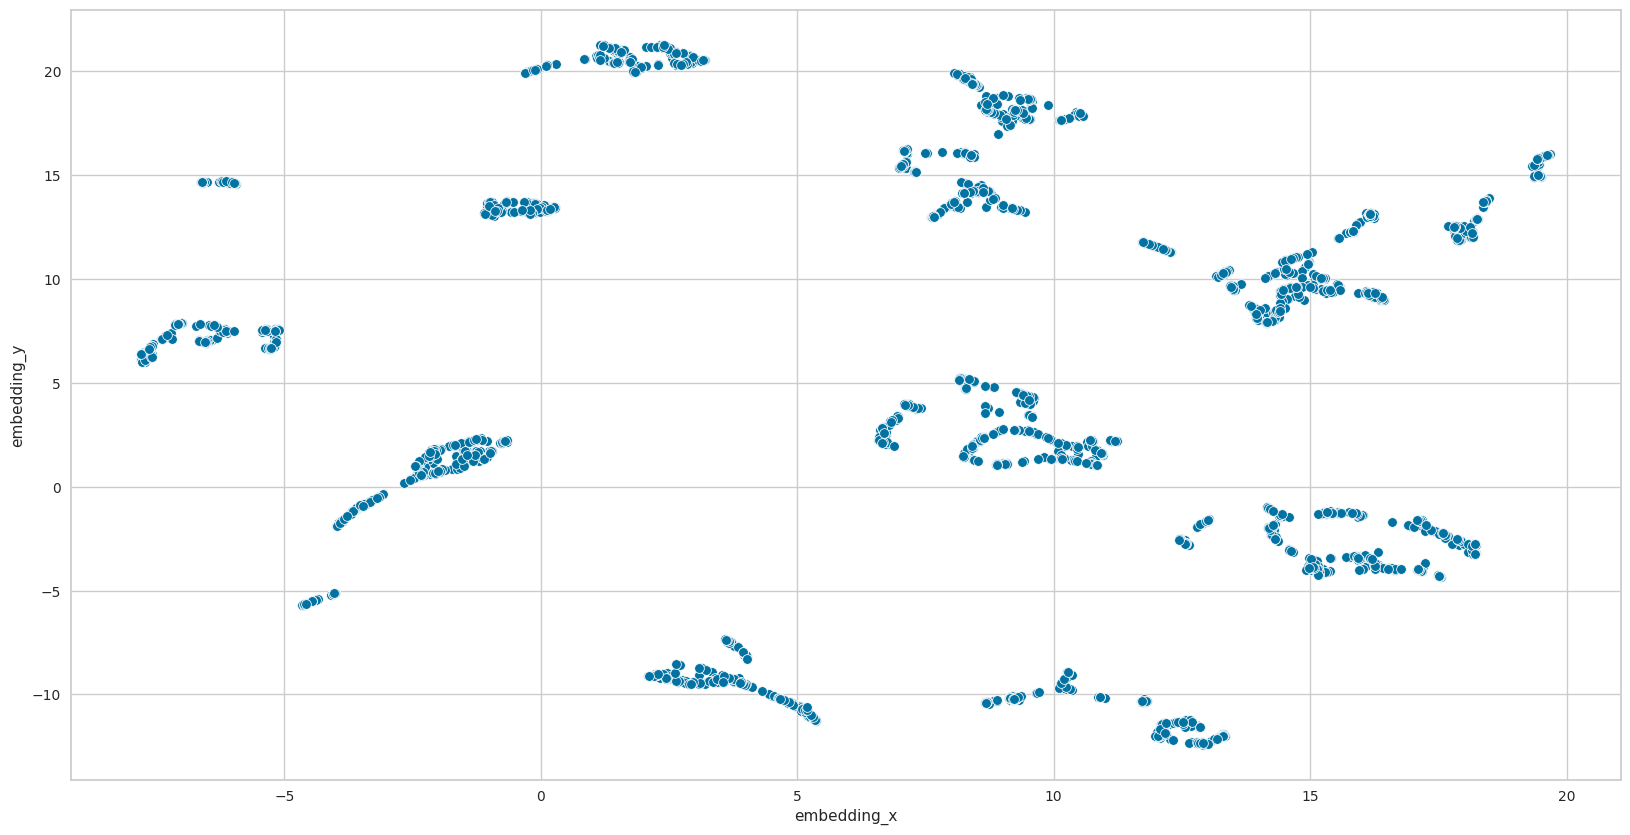

In [57]:
reducer = umap.UMAP(random_state= 42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
plt.figure(figsize=(20,10))
sns.scatterplot(x='embedding_x', y='embedding_y', data = df_pca)


# 5.0 Data preparation

In [90]:
df5 = df4.copy()

In [91]:
ss = pp.StandardScaler()


df5['gross_revenue'] = mms.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = mms.fit_transform(df5[['recency_days']])
df5['purchases'] = mms.fit_transform(df5[['purchases']])
df5['unique_products_purchased'] = mms.fit_transform(df5[['unique_products_purchased']])
df5['items_purchased'] = mms.fit_transform(df5[['items_purchased']])
df5['avg_ticket'] = mms.fit_transform(df5[['avg_ticket']])
df5['avg_recency_days'] = mms.fit_transform(df5[['avg_recency_days']])
df5['frequency'] = mms.fit_transform(df5[['frequency']])
df5['number_returns'] = mms.fit_transform(df5[['number_returns']])
df5['monetary_returns'] = mms.fit_transform(df5[['monetary_returns']])
df5['avg_basket_size'] = mms.fit_transform(df5[['avg_basket_size']])
df5['unique_avg_basket'] = mms.fit_transform(df5[['unique_avg_basket']])
df5['delta_buy_return'] = mms.fit_transform(df5[['delta_buy_return']])

# 6.0 Feature Selection

In [93]:
df6 = df5.copy()

# 7.0 HyperParameter Fine-Tunning

In [163]:
X = df6.drop(columns = ['customer_id'])

In [164]:
clusters = np.arange(2, 8, 1)

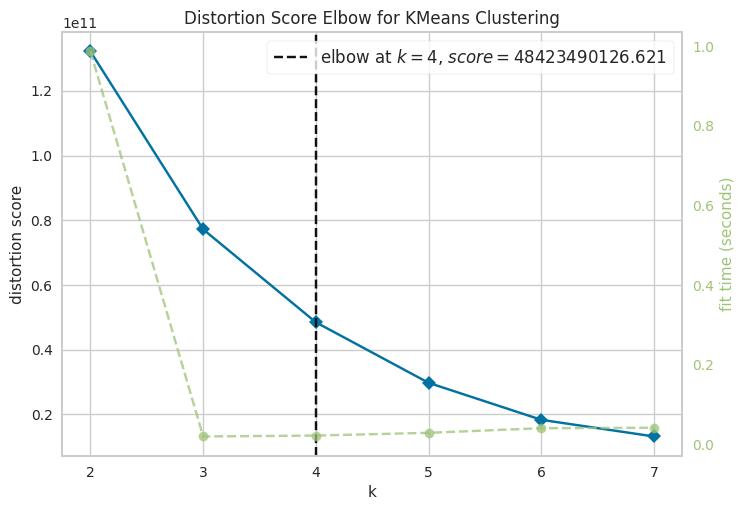

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [165]:
plt.rcParams['font.sans-serif'] = 'DejaVu Sans' 
kmeans = KElbowVisualizer (c.KMeans( n_init = 10), k=clusters, timing = True)
kmeans.fit(X)
kmeans.show()

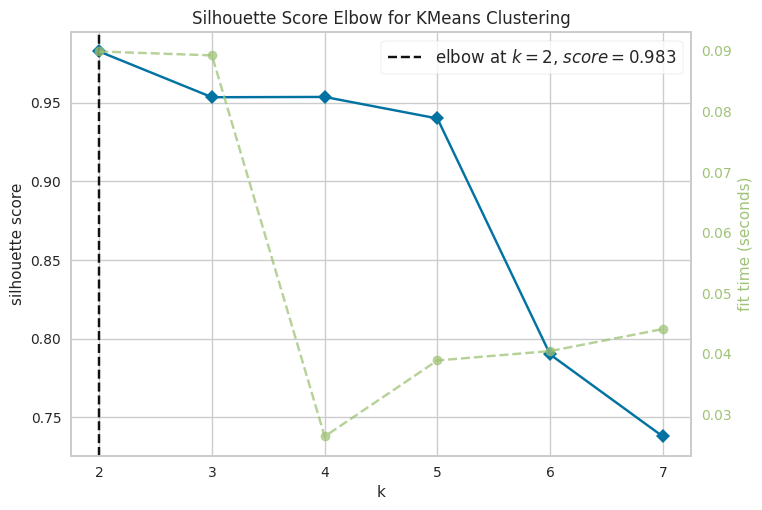

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [166]:
kmeans = KElbowVisualizer (c.KMeans( n_init = 10), k=clusters, metric='silhouette', timing = True)
kmeans.fit(X)
kmeans.show()

## 7.1 Silhouette Analysis

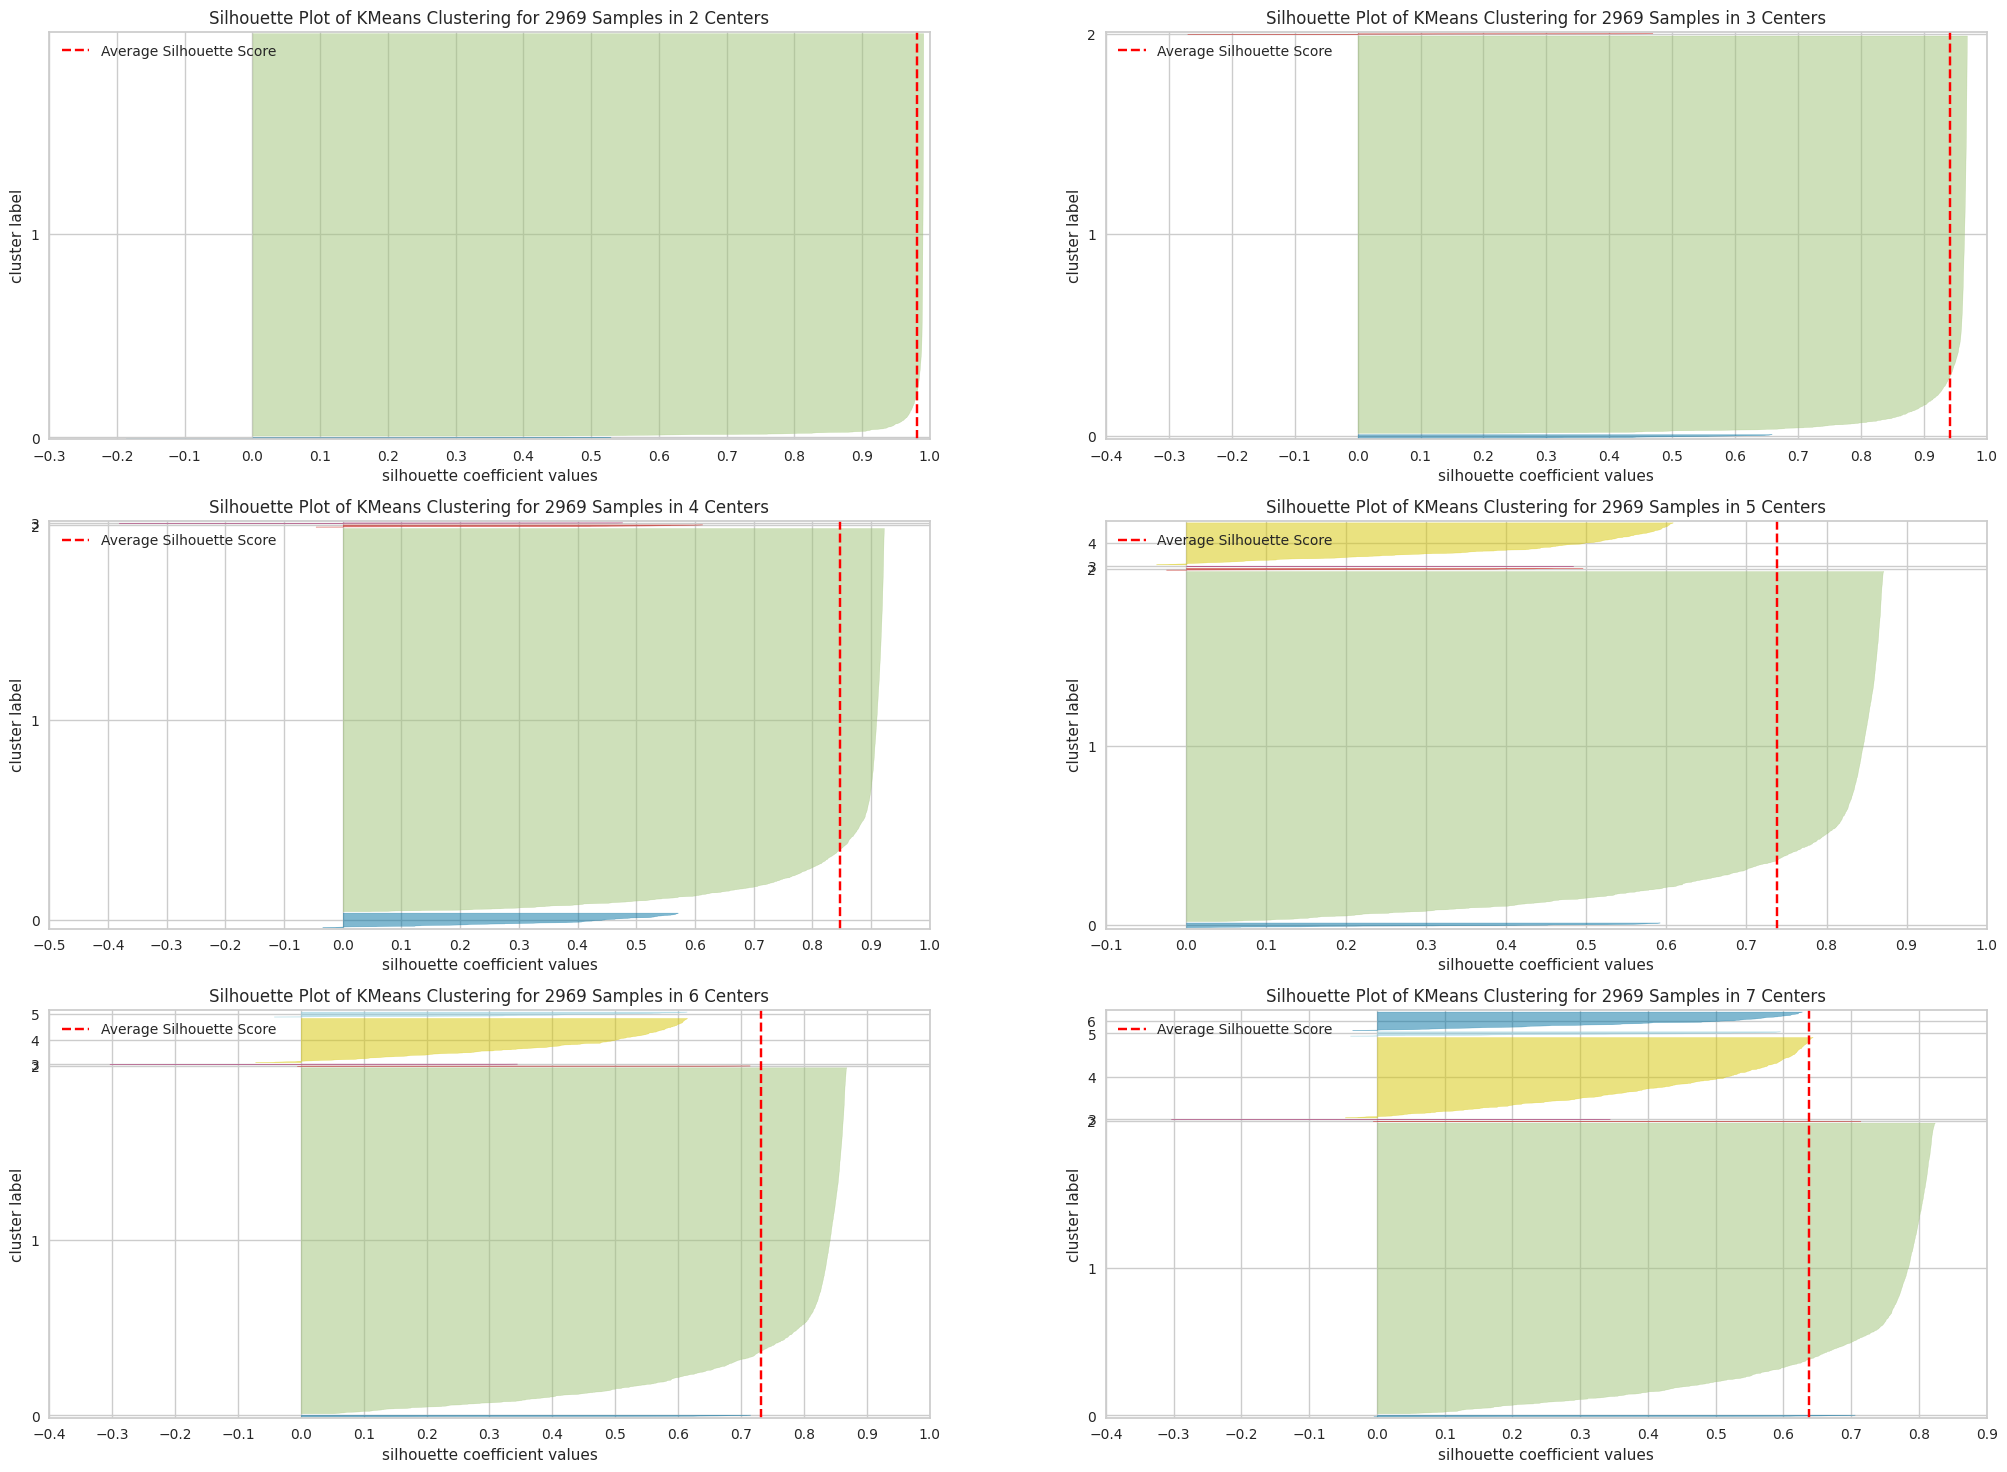

In [167]:
fig, ax = plt.subplots(3, 2, figsize=(25,18) )

for k in clusters:
    km = c.KMeans(n_clusters=k, n_init=10, init='random', max_iter = 100, random_state = 42)
    q, mod = divmod(k, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax= ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

# 8.0 Model Training

## 8.1 K-Means

In [168]:
# model definition
k = 7
kmeans = c.KMeans(init='random', n_clusters = k, n_init= 10, max_iter = 500, random_state = 42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.2 Cluster Validation

In [169]:
print(f'WSS:{kmeans.inertia_}')
print(f'SS:{mt.silhouette_score(X, labels)}')

WSS:39682871275.2284
SS:0.6377055075970582


# 9.0 Cluster Analysis

In [170]:
df9 = df6.copy()
df9['cluster'] = labels


## 9.1 Visualization Inspection Silhouette

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


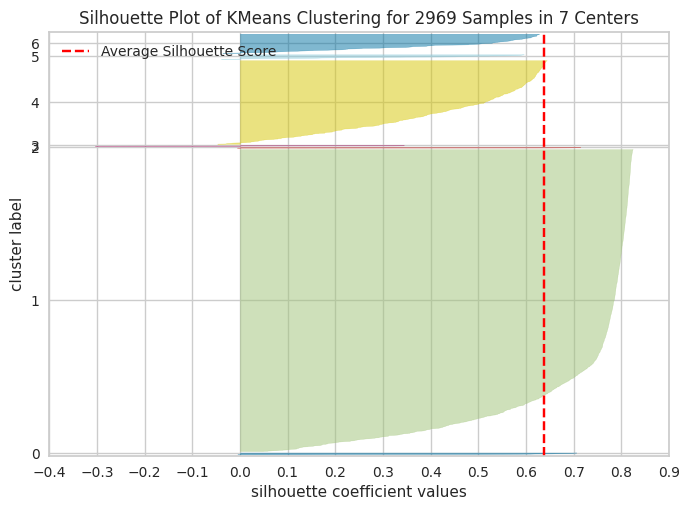

In [171]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2 2D Plot

In [173]:
df_viz = df9.drop(columns='customer_id', axis = 1)
# sns.pairplot(df_viz, hue = 'cluster')

## 9.3 UMAP

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

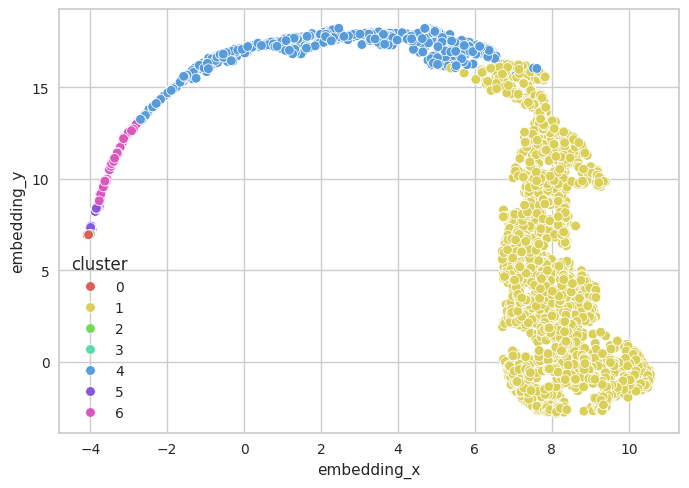

In [174]:
reducer = umap.UMAP(n_neighbors=30, random_state= 42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette = sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())), data = df_viz)


## 9.4 Cluster Profile

In [230]:
# Number of customers
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100* (df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg gross_revenue
df_gross = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_gross, on='cluster', how='left')


# Avg recency_days
df_recency_days = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_recency_days, on='cluster', how='left')

# # Avg invoice_no
# df_invoice_no = df9[['invoice_no','cluster']].groupby('cluster').mean().reset_index()
# df_cluster = pd.merge(df_cluster, df_invoice_no, on='cluster', how='left')

# Avg ticket
df_ticket = df9[['avg_ticket','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, on='cluster', how='left')
df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,avg_ticket
0,0,209,7.039407,9271.814976,21.545455,67.571837
1,1,2727,91.849107,1364.574030,68.174184,27.007940
2,2,26,0.875716,46904.613846,15.884615,329.047043
3,3,7,0.235770,183459.070000,6.142857,8250.866318


### Cluster 01: (Candidato à Insider)
    - Número de Customers: 6 (0.13% do customers)
    - Recência em Média: 7 dias
    - Compras em média no último ano: 89 compras
    - Receita em média no último ano: $182.182,00

### Cluster 02: 
    - Número de Customers: 31 (0.71% do customers)
    - Recência em Média: 14 dias
    - Compras em média no último ano: 53 compras
    - Receita em média no último ano: $40.543,52

### Cluster 03: 
    - Número de Customers: 4335 (99% do customers)
    - Recência em Média: 92 dias
    - Compras em média no último ano: 5 compras
    - Receita em média no último ano: $1.372,57

# 10.0 Deploy To Production